# Module Import
## Module


* numpy : ndarray
* cv2 : image resize, 불러오기 등의 처리
* glob : 디렉토리 파일 탐색
* tensorflow : 모듈 설계
* itertools : list iterate

In [1]:
import numpy as np
import cv2
import sys
import os
import glob
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from itertools import chain, repeat, cycle
from sklearn.model_selection import train_test_split

# Colab 드라이브 마운트
##### 이후 $ cd gdrive/MyDrive/경로.. 로 기본 디렉토리 수정하여 사용
##### 이미지 데이터를 가지고 와서 train data 라벨링 진행해야 함

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/MyDrive/KT

/content/gdrive/MyDrive/KT


# 이미지 불러오기
##### glob.glob(path) 함수 결과를 sort하여 img데이터 들어오는 순서 고정
##### cv2.imread() 함수로 img를 읽어오게 됨
  - cv2.IMREAD_COLOR : 컬러 이미지 불러올 때 쓰는 옵션
##### cv2.resize() : 크기 조절
  - dsize를 고정함으로써 원하는 크기로 불러온 이미지 데이터 수정 가능

##### 256.0으로 나누어 float데이터 타입을 유지하면서 normalize





In [4]:
folder = "Image/*"

In [5]:
# get img list from path
image_folders = sorted(glob.glob(folder))

In [6]:
image_folders.remove('Image/info')

In [7]:
files = []
each_class_num = []
for folder in image_folders:
  temp = sorted(glob.glob(folder + "/*.jpg"))
  temp.extend(sorted(glob.glob(folder + "/*.png")))
  temp.extend(sorted(glob.glob(folder + "/*.jpeg")))
  temp.extend(sorted(glob.glob(folder + "/*.jfif")))
  files.extend(temp)
  each_class_num.append(len(temp))

In [8]:
# read image from files list & reshape
# train_img shape : ( , 256, 256, 3)
train_img = np.array(np.array([cv2.resize(cv2.imread(file, cv2.IMREAD_COLOR), dsize=(256, 256),
                                 interpolation=cv2.INTER_LINEAR).astype(np.float64) for file in files]))

In [17]:
image_num = train_img.shape[0]
labels = 4
train_label = np.array(list(chain.from_iterable((repeat(n, k) for (n, k) in zip(range(labels), each_class_num)))))

In [18]:
# normalize
train_img = train_img / (256.0)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(train_img, train_label, test_size=0.1, stratify=train_label, random_state=34)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, stratify=y_train, random_state=12)

# Model Architecture

**코드가 조금 더러움 주의**

기본적으로 ResNet의 구조를 가지고 있는 NN으로 구성
## Hyperparameters
##### **수정 불가능한 hyperparameter**
  - input_img_shape : 256*256으로 고정
  - input_channel : RGB 3채널 이미지

##### **수정 가능한 hyperparmeter**
  - layer1_output_channel : layer1 의 output channel개수
  - layer1_kernel_size : ResNet 처음 conv kernel_size는 7*7 이용
  - layer2_output_channel : layer2 의 output channel개수 (== layer1_output_channel)
  - layer3_output_channel : layer3 의 output channel개수 (layer2_output_channel * 2)
  - res_kernel_size : resNet에서는 기본적으로 첫번째 conv 제외 3*3 kernel로 고정

## Layers
1. layer1 : convolution + pooling
2. layer2 : conv + norm + relu + conv + norm + relu + add
3. layer3 : conv + norm + relu + conv + norm + relu + identity + add
4. flatten : 분류기에 넣기 위해 flatten진행
5. classifier : 분류기, FC layer이용, ResNet에서는 FC layer의 Weight개수가 많으므로 한개의 FC layer만 사용

### 1*1 Convolution
layer2에서 사용하는 res_unit2의 경우, 이미지 데이터가 들어갈 때 layer2_output_channel개로 들어가지만, 나올 때 layer3_output_channel로 나오게 되는데, channel개수를 맞추어주기 위해서 convolution진행.
이미지 크기도 res_unit2의 첫번째 convolution에서 stride (2, 2)로 진행하므로 반으로 줄어들게 되므로 1*1 convolution도 stride (2, 2)로 진행

In [20]:
# Hyperparameters
global input_img_shape, input_channel, layer1_output_channel, layer1_kernel_size, res_kernel_size, layer2_output_channel, layer3_output_channel
input_img_shape = (256, 256, 3)
input_channel = 3
layer1_output_channel = 6
layer1_kernel_size = (7, 7)
layer2_output_channel = 6
layer3_output_channel = 12

# overall residual units num = num_residual_units * num_residual_layers 
res_kernel_size = (11, 11)

In [21]:
from tensorflow.python.keras.activations import softmax
class cnn_model(tf.keras.Model):
  global input_img_shape, input_channel, layer1_output_channel, layer1_kernel_size, res_kernel_size, layer2_output_channel, layer3_output_channel
  def __init__(self):
    super(cnn_model, self).__init__()
    
    self.conv1 = layers.Conv2D(layer1_output_channel, layer1_kernel_size, strides=(2, 2), 
                       padding='same', input_shape=input_img_shape, activation='relu')
    self.pool1 = layers.MaxPool2D(pool_size=(2, 2))
    self.conv2_t = layers.Conv2D(layer2_output_channel, res_kernel_size, padding='same')
    self.batchnorm1 = layers.BatchNormalization()
    self.relu1 = layers.ReLU()
    self.conv2 = layers.Conv2D(layer2_output_channel, res_kernel_size, padding='same')
    self.batchnorm2 = layers.BatchNormalization()
    self.relu2 = layers.ReLU()
    self.add1 = layers.Add()
    
    self.conv3 = layers.Conv2D(layer3_output_channel, res_kernel_size, strides=(2, 2), padding='same')
    self.batchnorm3 = layers.BatchNormalization()
    self.relu3 = layers.ReLU()
    
    self.conv4 = layers.Conv2D(layer3_output_channel, res_kernel_size, padding='same')
    self.batchnorm4 = layers.BatchNormalization()
    self.relu4 = layers.ReLU()
    self.identity1 = layers.Conv2D(layer3_output_channel, (1, 1), padding='same', strides=(2, 2))
    self.add2 = layers.Add()

    self.flat = layers.Flatten()
    self.fc1 = layers.Dense(4)

  def call(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x_t = self.conv2_t(x)
    x_t = self.batchnorm1(x_t)
    x_t = self.relu1(x_t)
    x_t = self.conv2(x_t)
    x_t = self.batchnorm2(x_t)
    x_t = self.relu2(x_t)
    x = self.add1([x, x_t])
    #print(x.shape)
    x_t = self.conv3(x)
    x_t = self.batchnorm3(x_t)
    x_t = self.relu3(x_t)
    x_t = self.conv4(x_t)
    x_t = self.batchnorm4(x_t)
    x_t = self.relu4(x_t)
    x = self.identity1(x)
    x = self.add2([x, x_t])

    x = self.flat(x)
    x = self.fc1(x)
    probs = softmax(x)
    return probs

In [38]:
model = cnn_model()

model optimizer, loss등 정의 compile

In [39]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

train

In [40]:
# Train Hyperparameters
epoch = 50
batch = 10

In [41]:
filename = 'checkpoint.ckpt'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# , callbacks=[checkpoint, earlystopping]

In [42]:
history = model.fit(x_train, y_train, epochs=epoch, validation_data=(x_val, y_val) , callbacks=[checkpoint, earlystopping])

Epoch 1/50
13/14 [==========================>...] - ETA: 0s - loss: 3.6631 - accuracy: 0.4207
Epoch 00001: val_loss improved from inf to 1.73466, saving model to checkpoint.ckpt
14/14 [==============================] - 2s 107ms/step - loss: 3.5537 - accuracy: 0.4339 - val_loss: 1.7347 - val_accuracy: 0.3784
Epoch 2/50
13/14 [==========================>...] - ETA: 0s - loss: 1.1393 - accuracy: 0.6514
Epoch 00002: val_loss did not improve from 1.73466
14/14 [==============================] - 1s 66ms/step - loss: 1.1198 - accuracy: 0.6543 - val_loss: 3.0975 - val_accuracy: 0.2919
Epoch 3/50
13/14 [==========================>...] - ETA: 0s - loss: 0.7682 - accuracy: 0.7644
Epoch 00003: val_loss improved from 1.73466 to 1.59103, saving model to checkpoint.ckpt
14/14 [==============================] - 1s 77ms/step - loss: 0.7746 - accuracy: 0.7633 - val_loss: 1.5910 - val_accuracy: 0.3730
Epoch 4/50
13/14 [==========================>...] - ETA: 0s - loss: 0.4469 - accuracy: 0.8173
Epoch 0000

#Load Model

In [43]:
model_fi = cnn_model()
model_fi.load_weights(filename)
model_fi.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
results = model_fi.evaluate(x_test, y_test)

3/3 [==============================] - 1s 17ms/step - loss: 0.7605 - accuracy: 0.7536


In [45]:
print('test loss, test acc:', results)

test loss, test acc: [0.7604793906211853, 0.7536231875419617]


In [46]:
model_fi.summary()

Model: "cnn_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          multiple                  888       
                                                                 
 max_pooling2d_4 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_25 (Conv2D)          multiple                  4362      
                                                                 
 batch_normalization_16 (Bat  multiple                 24        
 chNormalization)                                                
                                                                 
 re_lu_16 (ReLU)             multiple                  0         
                                                                 
 conv2d_26 (Conv2D)          multiple                  

#Train history Graph

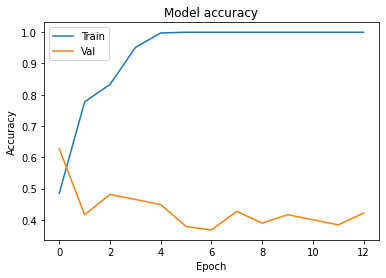

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

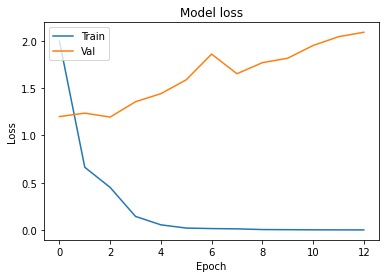

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Save model

In [ ]:
model_fi.save("cnnmodel_220103_rev")

# Loading Model

In [ ]:
import tensorflow as tf
import numpy as np
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/KT

/content/gdrive/MyDrive/KT


In [9]:
cnn_model = tf.keras.models.load_model("cnnmodel_211231_layer1_7_res_11")

In [10]:
# test file
file = "GANned_image_1.jpg"

In [11]:
img = np.array(np.array([cv2.resize(cv2.imread(file, cv2.IMREAD_COLOR), dsize=(256, 256),
                                 interpolation=cv2.INTER_LINEAR).astype(np.float64)])) / (256.0)

In [12]:
label = {0: "Mountain", 1:"Ocean", 2:"Tower", 3:"Grass"}

In [13]:
result = np.array(cnn_model(img))

In [14]:
# returning value
probability = []

In [15]:
for i in range(4):
  probability.append([label[i], str(round(100* result[0][i], 2))])